## Project: Deep Learning for Vulnerability Detection in Code Functions: A Bi-LSTM model

## 1.0. Data Load

### 1.1. Data dictionary
|#|Features| Column Name in the CSV |Description |
|:--:|:-------|:-----------------------|:-------------------------------------------------------------------------------------|
|1|Access Complexity|*access_complexity*|Reflects the complexity of the attack required to exploit the software feature misuse the vulnerability
|2|Authentication Required|*authentication_required*|If authentication is required to exploit the vulnerability|
|3|Availability Impact|*availability_impact*|Measures the potential impact to availability of a successfully exploited misuse vulnerability|
|4|CVE ID|*cve_id*|Common Vulnerabilities and Exposures ID|
|5|CVE Page|*cve_page*|CVE Details web page link for that CVE|
|6|CWE ID|*cwe_id*|Common Weakness Enumeration ID|
|7|Confidentiality Impact|*confidentiality_impact*|Measures the potential impact on confidentiality of a successfully exploited misuse vulnerability|
|8|Integrity Impact|*integrity_impact*|Measures the potential impact to integrity of a successfully exploited misuse vulnerability|
|9|Publish Date|*publish_date*|Publish date of the CVE|
|10|CVSS Score|*score*|The relative severity of software flaw vulnerabilities|
|11|CVE Summary|*summary CVE*|summary information|
|12|Update Date|*update_date*|Update date of the CVE|
|13|Commit ID|*commit_id*|Commit ID in code repository, indicating a mini-version|
|14|Commit Message|*commit_message*|Commit message from developer|
|15|Files Changed|*files_changed*|All the changed files and corresponding patches|
|16|func_after|*func_after*|The function after the vulnerability being fixed|
|17|func_before|*func_before*|The function before the vulnerability being fixed (if "vul" labeled as "1", then is the vulnerable function)|
|18|Programming Language|*lang*|Project programming language|
|19|lines_after|*lines_after*|The modified lines in the function after the vulnerability being fixed|
|20|lines_before|*lines_before*|The modified lines in the function before the vulnerability being fixed|
|21|Project|*project*|Project name|
|22|Reference Link|*ref_ink*|Reference link in the CVE page|
|23|Mini-version After Fix|*version_after_fix*|Mini-version ID after the fix|
|24|Mini-version Before Fix|*version_before_fix*|Mini-version ID before the fix|
|25|Vulnerability|*vul*|"1" means vulnerable function and "0" means non-vulnerable function|
|26|vul_func_with_fix|*vul_func_with_fix*|The code comments showing how the vulnerability was fixed|

### 1.2. Load the dataset

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import re

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from datasets import load_dataset
from pygments.lexers import CLexer
from pygments import lex


# Extend number of columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from datasets import load_dataset

# Load dataset from HuggingFace
ds = load_dataset("starsofchance/MSR_data_cleaned")

# Convert to pandas DataFrame
entire_data = ds['train'].to_pandas()

# Preview
entire_data.head()

# Extract texts and labels
texts = entire_data["func_before"].astype(str).tolist()
labels = entire_data["vul"].values  # 0 / 1

print("Samples:", len(texts),
      "  Positive labels:", labels.sum())

Samples: 150909   Positive labels: 8720


In [14]:
# Data information
df = entire_data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150909 entries, 0 to 150908
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   idx                           150909 non-null  int64 
 1   func_before                   150909 non-null  object
 2   Vulnerability Classification  106153 non-null  object
 3   vul                           150909 non-null  int64 
 4   func_after                    150909 non-null  object
 5   patch                         150909 non-null  object
 6   CWE ID                        121932 non-null  object
 7   lines_before                  6616 non-null    object
 8   lines_after                   7798 non-null    object
dtypes: int64(2), object(7)
memory usage: 10.4+ MB


## 2.0. Data Pre-processing


### 2.1. Data exploration

In [15]:
import pygments
from pygments.lexers import CLexer
from pygments import lex

lexer = CLexer()

def preprocess_code(code: str) -> str:
    code = re.sub(r'//.*', '', code)  # single-line comments
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # multi-line
    code = re.sub(r'".*?"', '', code)  # string literals
    return code

def tokenize_code(code: str):
    code = preprocess_code(code)
    tokens = []
    for tok_type, tok_value in lex(code, lexer):
        tok_value = tok_value.strip()
        if tok_value:
            tokens.append(tok_value)
    return tokens

tokenized_texts = [tokenize_code(c) for c in tqdm(texts, desc="Tokenizing")]

Tokenizing: 100%|██████████| 150909/150909 [04:14<00:00, 593.43it/s]


In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

token_freq = Counter(tok for seq in tokenized_texts for tok in seq)

min_freq = 5
vocab = {tok for tok, freq in token_freq.items() if freq >= min_freq}

word_index = {tok: i+1 for i, tok in enumerate(sorted(vocab))}
vocab_size = len(word_index) + 1
print("Vocab size:", vocab_size)

def tokens_to_ids(tokens):
    return [word_index[t] for t in tokens if t in word_index]

sequences = [tokens_to_ids(seq) for seq in tokenized_texts]

maxlen = 300
X = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
y = labels
print("X shape:", X.shape, " y shape:", y.shape)

Vocab size: 161622
X shape: (150909, 300)  y shape: (150909,)


In [18]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape,
      "Val:",   X_val.shape,
      "Test:",  X_test.shape)


Train: (96581, 300) Val: (24146, 300) Test: (30182, 300)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 128)       │    20,687,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 300, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 128)            │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,794,882 (79.33 MB)

 Trainable params: 20,794,882 (79.33 MB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 0.5306648351648352, 1: 8.652660813474288}
Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.7072 - loss: 0.6141 - val_accuracy: 0.7839 - val_loss: 0.4979
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.8313 - loss: 0.4169 - val_accuracy: 0.7265 - val_loss: 0.5817
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.9008 - loss: 0.2453 - val_accuracy: 0.7828 - val_loss: 0.4944
Epoch 4/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9442 - loss: 0.1440 - val_accuracy: 0.8616 - val_loss: 0.4063
Epoch 5/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9626 - loss: 0.0930 - val_accuracy: 0.8797 - val_loss: 0.4006
Epoch 6/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9724 - loss: 0.0743 - val_accuracy: 0.8715 - val_loss: 0.4538
Epoch 7/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9756 - loss: 0.0622 - val_accuracy: 0.8657 - val_loss: 0.5509
Epoch 8/10
755/755 ━━━━━━━━━━

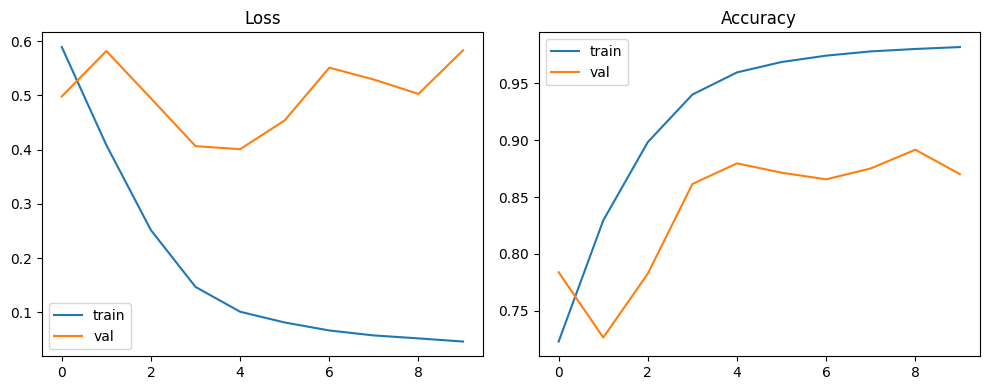

944/944 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
Classification report:

              precision    recall  f1-score   support

           0     0.9660    0.8915    0.9273     28438
           1     0.2162    0.4880    0.2996      1744

    accuracy                         0.8682     30182
   macro avg     0.5911    0.6897    0.6135     30182
weighted avg     0.9227    0.8682    0.8910     30182

Confusion matrix:

[[25353  3085]
 [  893   851]]


In [21]:
# =========================
# 6. Define Attention layer
# =========================
class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(1,),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, timesteps, features)
        e = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch, timesteps, 1)
        alpha = K.softmax(e, axis=1)               # attention weights
        context = inputs * alpha                   # weighted features
        return K.sum(context, axis=1)              # (batch, features)

# =========================
# 7. Build Bi-LSTM + Attention model
# =========================
embedding_dim = 128
lstm_units = 64

inputs = layers.Input(shape=(maxlen,))
x = layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)(inputs)
x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
x = Attention()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# =========================
# 8. Class weights (handle imbalance)
# =========================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {int(c): float(w) for c, w in zip(np.unique(y_train), class_weights)}
print("Class weights:", class_weight_dict)

# =========================
# 9. Train model
# =========================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    class_weight=class_weight_dict
)

# =========================
# 10. Plot training history
# =========================
def plot_history(h):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train')
    plt.plot(h.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# =========================
# 11. Evaluate on test set
# =========================
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

print("Classification report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))